* Name: Zicheng Huang
* LIN: 830829001
* HW 3
* STAT_465_010

In [178]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from dwtest import dwtest
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.decomposition import PCA
import warnings
from sklearn.exceptions import DataConversionWarning


## 1

In [120]:
mydata= pd.read_csv(filepath_or_buffer='2017-18_NBA_salary.csv')
#print(mydata.head(5))
print(f"The missing value of NBA data: {mydata.isnull().sum().sum()}")
mydata = mydata.select_dtypes(include='number').copy()
mydata.dropna(axis=0, how='any', inplace=True)
print(f"Now, the missing value of NBA data: {mydata.isnull().sum().sum()}")

The missing value of NBA data: 8
Now, the missing value of NBA data: 0


In [121]:
print(mydata.shape)
print(mydata.describe())

(483, 25)
             Salary  NBA_DraftNumber         Age           G           MP  \
count  4.830000e+02       483.000000  483.000000  483.000000   483.000000   
mean   6.660622e+06        29.395445   26.273292   50.370600  1158.915114   
std    7.398214e+06        21.116033    4.274290   24.723561   809.627553   
min    4.608000e+04         1.000000   19.000000    1.000000     1.000000   
25%    1.471382e+06        10.500000   23.000000   29.500000   385.000000   
50%    3.218280e+06        25.000000   26.000000   59.000000  1151.000000   
75%    1.000000e+07        47.000000   29.000000   71.000000  1824.500000   
max    3.468255e+07        62.000000   41.000000   79.000000  2898.000000   

              PER         TS%        3PAr         FTr        ORB%  ...  \
count  483.000000  483.000000  483.000000  483.000000  483.000000  ...   
mean    13.315735    0.535387    0.337383    0.263404    4.893996  ...   
std      8.745666    0.112352    0.226894    0.294578    4.581519  ...   


* From the above, 
* Structure: 483 rows, 25 columns. We have 483 players and 25 variables.

## 3

['Salary', 'NBA_DraftNumber', 'Age', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%']


c:\Users\11527\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


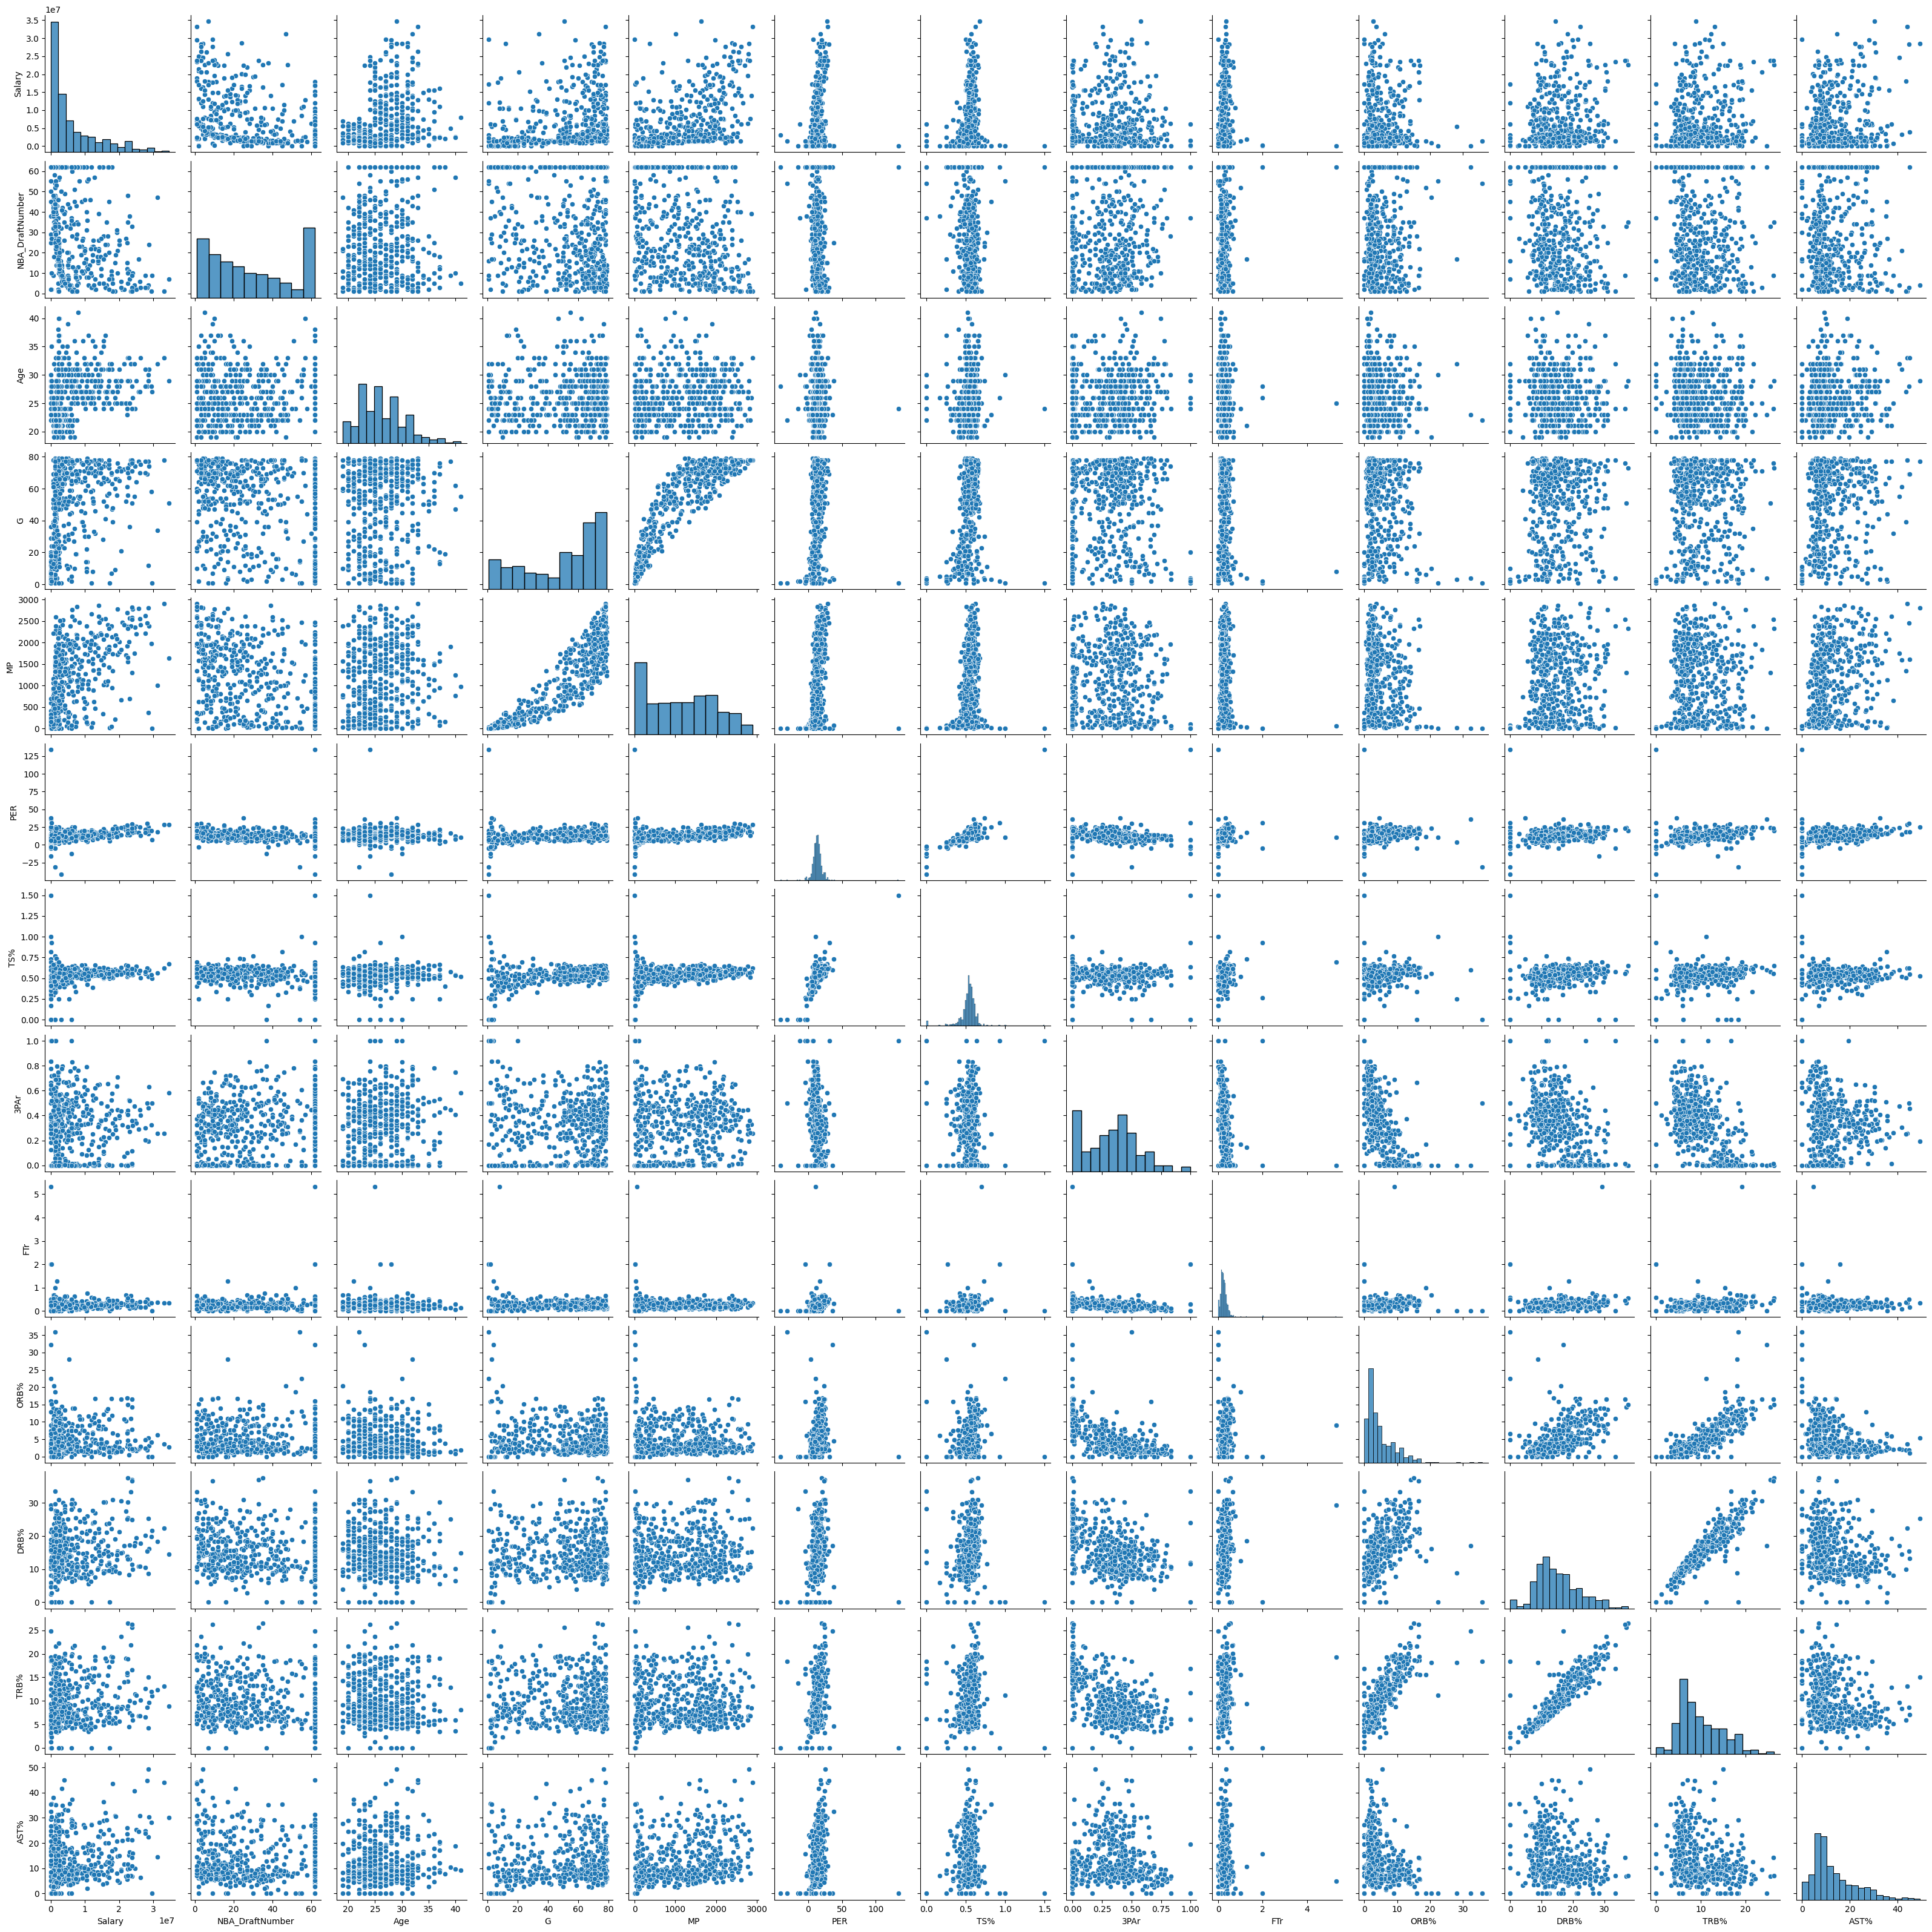

In [4]:
list01= list(mydata.columns.values[0:13])
list02= list(mydata.columns.values[13:26])

print(list01)
sns.pairplot(mydata[list01])

c:\Users\11527\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


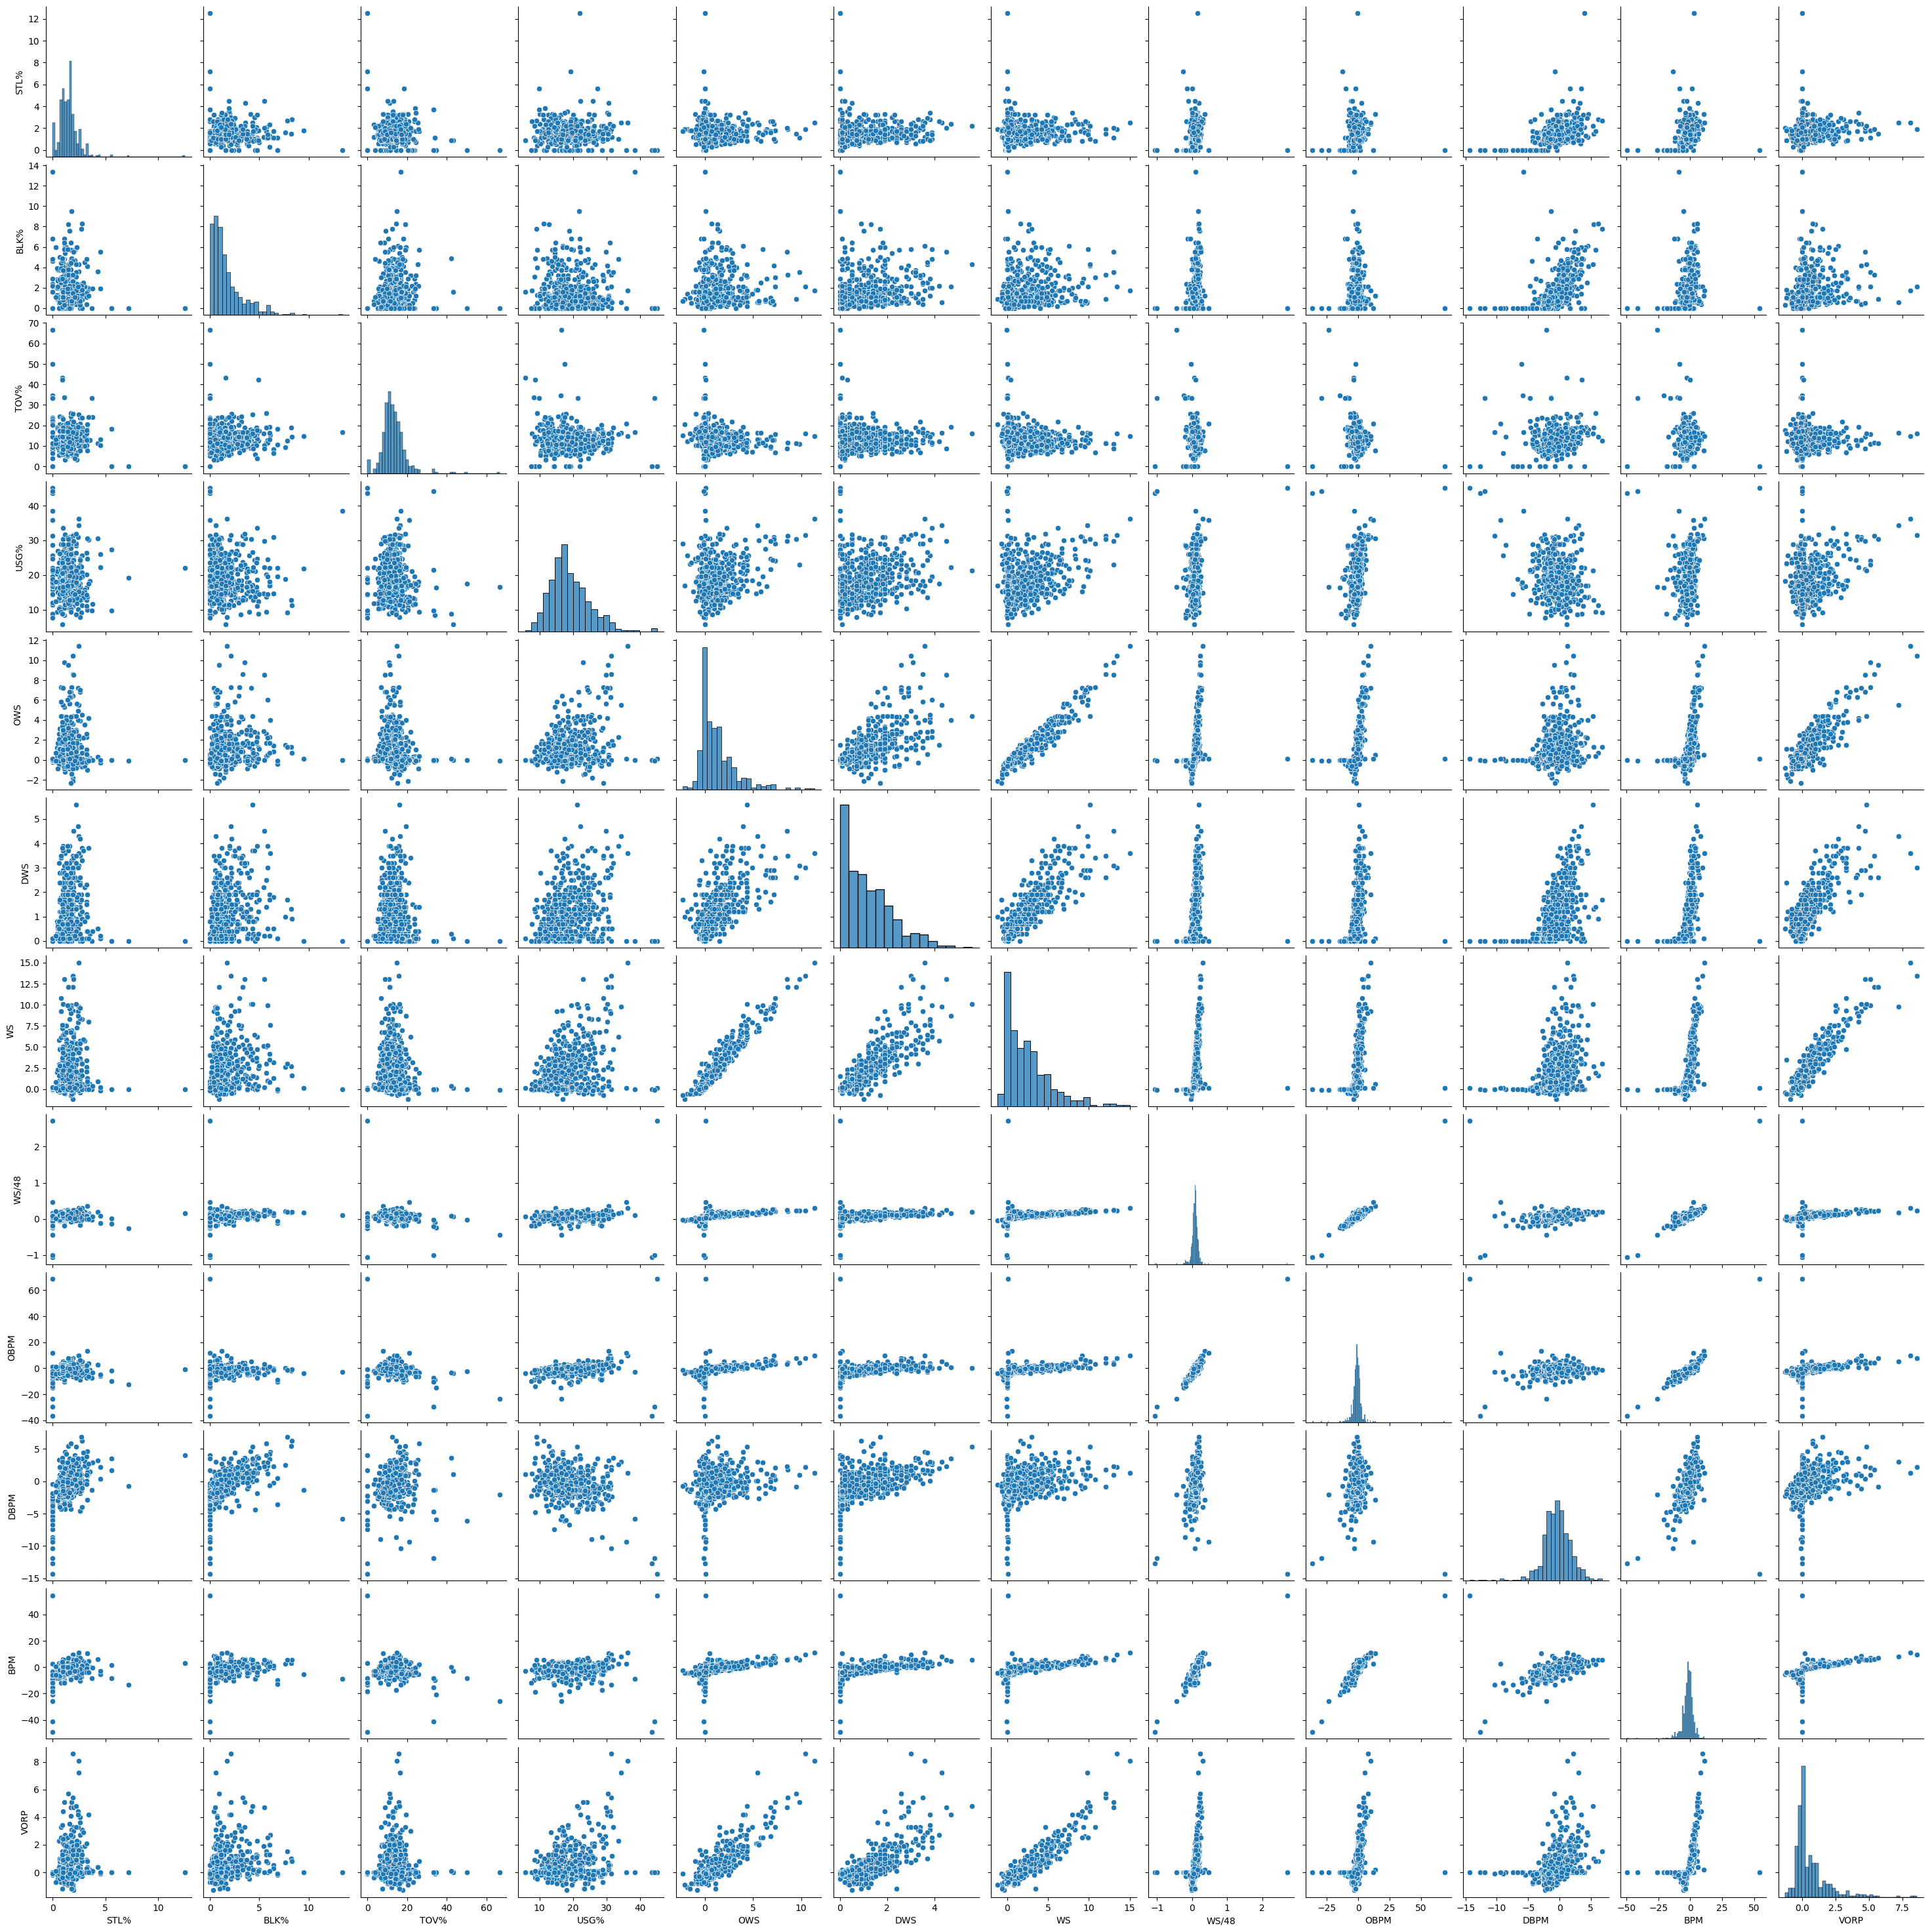

In [6]:
sns.pairplot(mydata[list02])

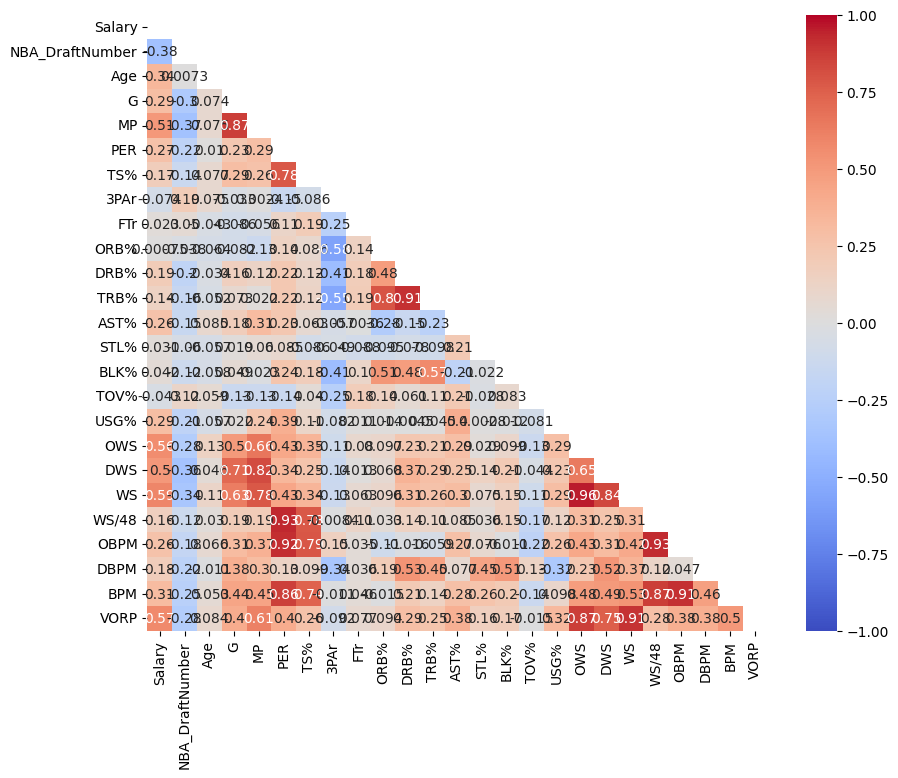

In [6]:
corr = mydata.corr()
plt.figure(figsize=(10, 8)) 
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
# Display the heatmap
plt.show()


From the above charts, we can notice that some variables have a low correlation with salary, and some correlation coefficients between the regressors are high. Therefore, we should concern the problem of collinearity. 

## 4

In [7]:
target = mydata.columns[0]
print(target)

features = mydata.columns[1:].tolist()
features_escaped = ["Q('{}')".format(feat) if any(char in feat for char in "%/()") or feat[0].isdigit() else feat for feat in features]
formula1 = target + " ~ " + " + ".join(features_escaped)
print(formula1)
full = smf.ols(formula=formula1, data=mydata).fit()
print(full.summary())

Salary
Salary ~ NBA_DraftNumber + Age + G + MP + PER + Q('TS%') + Q('3PAr') + FTr + Q('ORB%') + Q('DRB%') + Q('TRB%') + Q('AST%') + Q('STL%') + Q('BLK%') + Q('TOV%') + Q('USG%') + OWS + DWS + WS + Q('WS/48') + OBPM + DBPM + BPM + VORP
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     23.13
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           4.74e-64
Time:                        13:54:56   Log-Likelihood:                -8132.6
No. Observations:                 483   AIC:                         1.632e+04
Df Residuals:                     458   BIC:                         1.642e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                 

In [12]:
# Anova
anova_table = sm.stats.anova_lm(full, type=2)
print(anova_table)

                    df        sum_sq       mean_sq           F        PR(>F)
NBA_DraftNumber    1.0  3.822828e+15  3.822828e+15  146.790018  1.684863e-29
Age                1.0  3.027898e+15  3.027898e+15  116.266067  2.604590e-24
G                  1.0  6.818750e+14  6.818750e+14   26.182828  4.577496e-07
MP                 1.0  5.174869e+15  5.174869e+15  198.706050  9.748372e-38
PER                1.0  2.058825e+14  2.058825e+14    7.905533  5.139920e-03
Q('TS%')           1.0  9.654785e+12  9.654785e+12    0.370727  5.429101e-01
Q('3PAr')          1.0  1.123131e+14  1.123131e+14    4.312630  3.838743e-02
FTr                1.0  1.626712e+13  1.626712e+13    0.624629  4.297412e-01
Q('ORB%')          1.0  4.581346e+13  4.581346e+13    1.759158  1.853906e-01
Q('DRB%')          1.0  2.902108e+14  2.902108e+14   11.143594  9.120057e-04
Q('TRB%')          1.0  1.647539e+14  1.647539e+14    6.326265  1.223755e-02
Q('AST%')          1.0  5.014424e+13  5.014424e+13    1.925452  1.659316e-01

* From ANOVA table above, we can notice that some variables are not significant at alpha 0f 0.05, but at least one is significantly different from 0. Therefore, we can perform the model diagnostics.

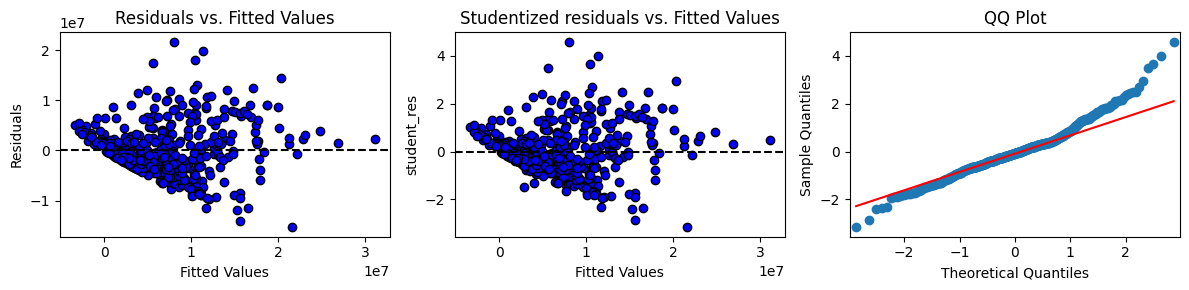

In [26]:
X = mydata.drop(['Salary'], axis=1).copy()
result = full.outlier_test()
student_res = result['student_resid']
res = full.resid
y_hat = full.predict(X)

#Plot
fig, axs = plt.subplots(1, 3, figsize=(12,3))

# residual vs. fitted values
axs[0].scatter(y_hat, res, color='blue', edgecolors='k')
axs[0].axhline(y=0, color='k', linestyle='--')
axs[0].set_title('Residuals vs. Fitted Values')
axs[0].set_xlabel('Fitted Values')
axs[0].set_ylabel('Residuals')

# studend_res vs yhat
axs[1].scatter(y_hat, student_res, color='blue', edgecolors='k')
axs[1].axhline(y=0, color='k', linestyle='--')
axs[1].set_title('Studentized residuals vs. Fitted Values')
axs[1].set_xlabel('Fitted Values')
axs[1].set_ylabel('student_res')


# QQ plot
sm.qqplot(student_res, line='q', ax=axs[2])
axs[2].set_title('QQ Plot')

plt.tight_layout()
plt.show()


In [16]:
#Independence
test_stat, P_value = dwtest(formula=formula1, data=mydata, alternative="two_sided")
print(f"D-W Statistic: {test_stat}; p_value: {P_value}")

D-W Statistic: 1.8082851049836797; p_value: 0.0384246047972234


We reject Null hypothesis, so they are not independent.

In [24]:
def test_normality(residuals) -> pd.DataFrame:

    test_names = []
    test_stats = []
    p_values = []

    sw = stats.shapiro(residuals)
    ks = sm.stats.diagnostic.kstest_fit(residuals, dist='norm')
    cvm = stats.cramervonmises(residuals, 'norm')
    ad = sm.stats.normal_ad(residuals)

    test_names.extend(['Shapiro-Wilk', 'Kolmogorov-Smirnov', 'Cramer-von Mises', 'Anderson-Darling'])
    test_stats.extend([sw[0], ks[0], cvm.statistic, ad[0]])
    p_values.extend([sw[1], ks[1], cvm.pvalue, ad[1]])

    df = pd.DataFrame({
        'Test Name': test_names,
        'Test Statistic': [round(stat, 5) for stat in test_stats],
        'p_value': [round(p_val, 5) for p_val in p_values]
    })

    return df

In [27]:
# Check Normality
check = test_normality(res)
print(check)

            Test Name  Test Statistic  p_value
0        Shapiro-Wilk         0.97066    0.000
1  Kolmogorov-Smirnov         0.09108    0.001
2    Cramer-von Mises        41.20704    0.000
3    Anderson-Darling         3.87436    0.000


There is serious violation for normality assumption.

In [19]:
#Test for Heteroscedasticity
test = sm.stats.het_breuschpagan(res, full.model.exog)
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
df = pd.DataFrame({
    'Item': name,
    'Value': test
})
print(df.set_index('Item',drop=True))

                                      Value
Item                                       
Lagrange multiplier statistic  7.098316e+01
p-value                        1.550295e-06
f-value                        3.287718e+00
f p-value                      4.434013e-07


We reject the null hypothese for Heteroscedasticity

## 6    

In [127]:
mydata['LSalary'] = np.log(mydata['Salary'])
target1 = mydata.columns[-1]
print(target1)
features = mydata.columns[1:-1].tolist()
features_escaped = ["Q('{}')".format(feat) if any(char in feat for char in "%/()") or feat[0].isdigit() else feat for feat in features]
formula2 = target1 + " ~ " + " + ".join(features_escaped)
print(formula2)
print(mydata.isnull().sum().sum())



LSalary
LSalary ~ NBA_DraftNumber + Age + G + MP + PER + Q('TS%') + Q('3PAr') + FTr + Q('ORB%') + Q('DRB%') + Q('TRB%') + Q('AST%') + Q('STL%') + Q('BLK%') + Q('TOV%') + Q('USG%') + OWS + DWS + WS + Q('WS/48') + OBPM + DBPM + BPM + VORP
0


In [30]:
TM = smf.ols(formula=formula2, data=mydata).fit()
print(TM.summary())

                            OLS Regression Results                            
Dep. Variable:                LSalary   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     24.06
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           3.76e-66
Time:                        14:09:36   Log-Likelihood:                -679.34
No. Observations:                 483   AIC:                             1409.
Df Residuals:                     458   BIC:                             1513.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.7042      0.974     

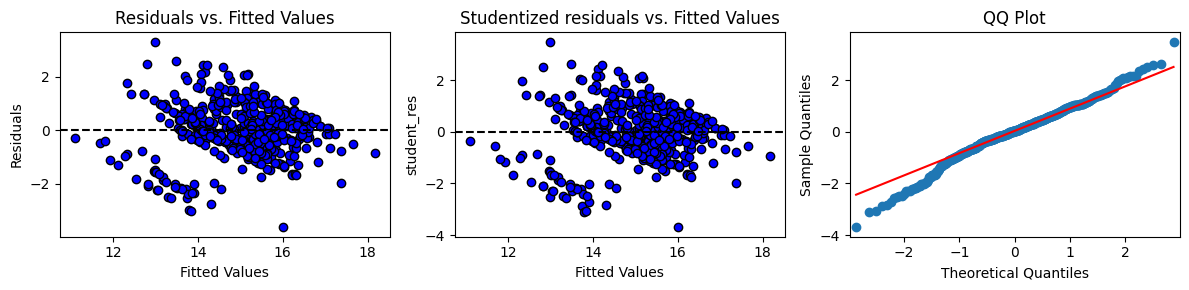

In [168]:
X1 = mydata.drop(['Salary','LSalary'], axis=1).copy()
# print(X1)
result1 = TM.outlier_test()
student_res2 = result1['student_resid']
res2 = TM.resid
y_hat1 = TM.predict(X1)


#Plot
fig, axs = plt.subplots(1, 3, figsize=(12,3))

# # residual vs. fitted values
axs[0].scatter(y_hat1, res2, color='blue', edgecolors='k')
axs[0].axhline(y=0, color='k', linestyle='--')
axs[0].set_title('Residuals vs. Fitted Values')
axs[0].set_xlabel('Fitted Values')
axs[0].set_ylabel('Residuals')

# # studend_res vs yhat
axs[1].scatter(y_hat1, student_res2, color='blue', edgecolors='k')
axs[1].axhline(y=0, color='k', linestyle='--')
axs[1].set_title('Studentized residuals vs. Fitted Values')
axs[1].set_xlabel('Fitted Values')
axs[1].set_ylabel('student_res')


# QQ plot
sm.qqplot(student_res2, line='q', ax=axs[2])
axs[2].set_title('QQ Plot')

plt.tight_layout()
plt.show()


In [33]:
#Independence
test_stat, P_value = dwtest(formula=formula2, data=mydata, alternative="two_sided")
print(f"D-W Statistic: {test_stat}; p_value: {P_value}")
#Normality
tnorm = test_normality(res2)
print(tnorm)

D-W Statistic: 1.9720960491846538; p_value: 0.7898010731453292
            Test Name  Test Statistic  p_value
0        Shapiro-Wilk         0.98678  0.00023
1  Kolmogorov-Smirnov         0.06192  0.00100
2    Cramer-von Mises         0.35235  0.09686
3    Anderson-Darling         2.04484  0.00003


The independent test is passed and the Cramer-von Mises test also passed the normality assumption after we do log transformation.

In [35]:
#Test for Heteroscedasticity
test = sm.stats.het_breuschpagan(res2, TM.model.exog)
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
df = pd.DataFrame({
    'Item': name,
    'Value': test
})
print(df.set_index('Item',drop=True))

                                      Value
Item                                       
Lagrange multiplier statistic  1.376965e+02
p-value                        6.158564e-18
f-value                        7.609853e+00
f p-value                      1.458009e-21


We reject the null hypothese for Heteroscedasticity

## 7

In [53]:
# VIF
def get_Vif(data, response_var=None) -> pd.DataFrame:
    if response_var:
        data_with_const = sm.add_constant(data.drop(response_var, axis=1))
    else:
        data_with_const = data
    vif = pd.DataFrame()
    vif["Variable"] = data_with_const.columns
    vif["VIF"] = [variance_inflation_factor(data_with_const.values, i) 
              for i in range(data_with_const.shape[1])]

    vif = vif[vif["Variable"] != "const"]

    return vif

In [56]:
#Condition Index
def condition_indices(dataframe, response_var=None):
    if response_var:
        X = dataframe.drop(response_var, axis=1)
    else:
        X=dataframe
    formula = "+".join(["Q('"+col+"')" for col in X.columns])
    x_design = np.asarray(patsy.dmatrix(f"{formula}", data=dataframe))

    # Getting the singular values from SVD
    _, sing_as, _ = np.linalg.svd(x_design)

    condition_index =[]
    for n in sing_as:
        ci = sing_as.max() / n
        condition_index.append(ci)
    
    eigen_vals = np.linalg.eigvals(np.dot(x_design.T, x_design))

    result = pd.DataFrame(
        {
        "Eigvenvalue": eigen_vals,
        "Condition_Index": condition_index
        }
    )
    
    return result


In [98]:
#VIF
print(get_Vif(mydata,['Salary', 'LSalary']))

           Variable           VIF
1   NBA_DraftNumber      1.342520
2               Age      1.079819
3                 G      7.060934
4                MP     14.225204
5               PER    111.433074
6               TS%      6.194013
7              3PAr      5.297330
8               FTr      1.263474
9              ORB%    316.727002
10             DRB%    681.928718
11             TRB%   1436.507667
12             AST%      3.458745
13             STL%      3.208711
14             BLK%      5.312844
15             TOV%      1.921716
16             USG%      6.886673
17              OWS   1325.576479
18              DWS    404.022191
19               WS   2679.552208
20            WS/48     68.627896
21             OBPM  10537.222382
22             DBPM   2304.619311
23              BPM  13004.117445
24             VORP     11.572767


In [140]:
# Condition Index
print(condition_indices(X1))
# print(TM.condition_number)


     Eigvenvalue  Condition_Index
0   9.669200e+08         1.000000
1   6.904199e+05        37.423002
2   1.173200e+05        90.784002
3   7.548690e+04       113.177341
4   4.852498e+04       141.160309
5   4.192815e+04       151.859660
6   2.053653e+04       216.986011
7   1.380944e+04       264.610611
8   1.066718e+04       301.072018
9   6.002803e+03       401.345350
10  2.215752e+03       660.594049
11  1.818340e+03       729.218619
12  1.024625e+03       971.432687
13  5.471025e+02      1329.416111
14  1.607608e+02      2452.478147
15  1.219484e+02      2815.835091
16  5.187663e+01      4317.271778
17  3.728862e+01      5092.219383
18  1.175177e+01      9070.758497
19  5.554498e+00     13193.890234
20  2.971497e+00     18038.798513
21  8.588537e-01     33553.333058
22  1.693572e-01     46900.842517
23  3.835614e-01     50208.567469
24  4.395712e-01     75560.255378


According to the above results, there is very serious collinearity here.

## 8

* Centerting Regressors

In [58]:
std_scaler = StandardScaler(with_std=False)
center_data = std_scaler.fit_transform(X1.to_numpy())
center_data = pd.DataFrame(center_data, columns=X1.columns)
print(get_Vif(center_data))

           Variable           VIF
0   NBA_DraftNumber      1.342520
1               Age      1.079819
2                 G      7.060934
3                MP     14.225204
4               PER    111.433074
5               TS%      6.194013
6              3PAr      5.297330
7               FTr      1.263474
8              ORB%    316.727002
9              DRB%    681.928718
10             TRB%   1436.507667
11             AST%      3.458745
12             STL%      3.208711
13             BLK%      5.312844
14             TOV%      1.921716
15             USG%      6.886673
16              OWS   1325.576479
17              DWS    404.022191
18               WS   2679.552208
19            WS/48     68.627896
20             OBPM  10537.222382
21             DBPM   2304.619311
22              BPM  13004.117445
23             VORP     11.572767


Centering data is not too much helpful here

* Ridge Trace

In [170]:
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X1.to_numpy())
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# print(X_scaled)

n_alphas = 200
alphas = np.linspace(start=0.1,stop=5,num=n_alphas)
y=mydata["LSalary"]
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False).fit(X_scaled, y)
    coefs.append(ridge.coef_)

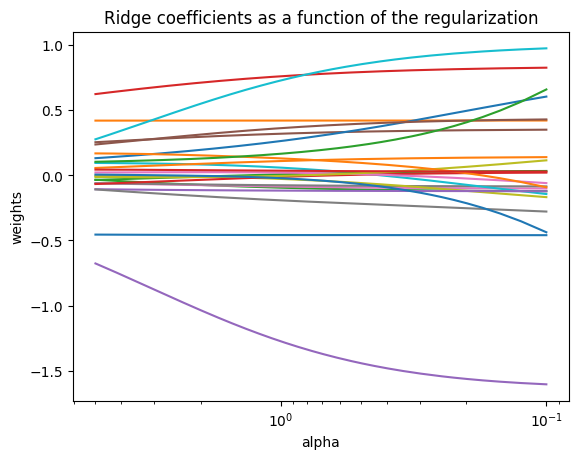

In [69]:
#Plot
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

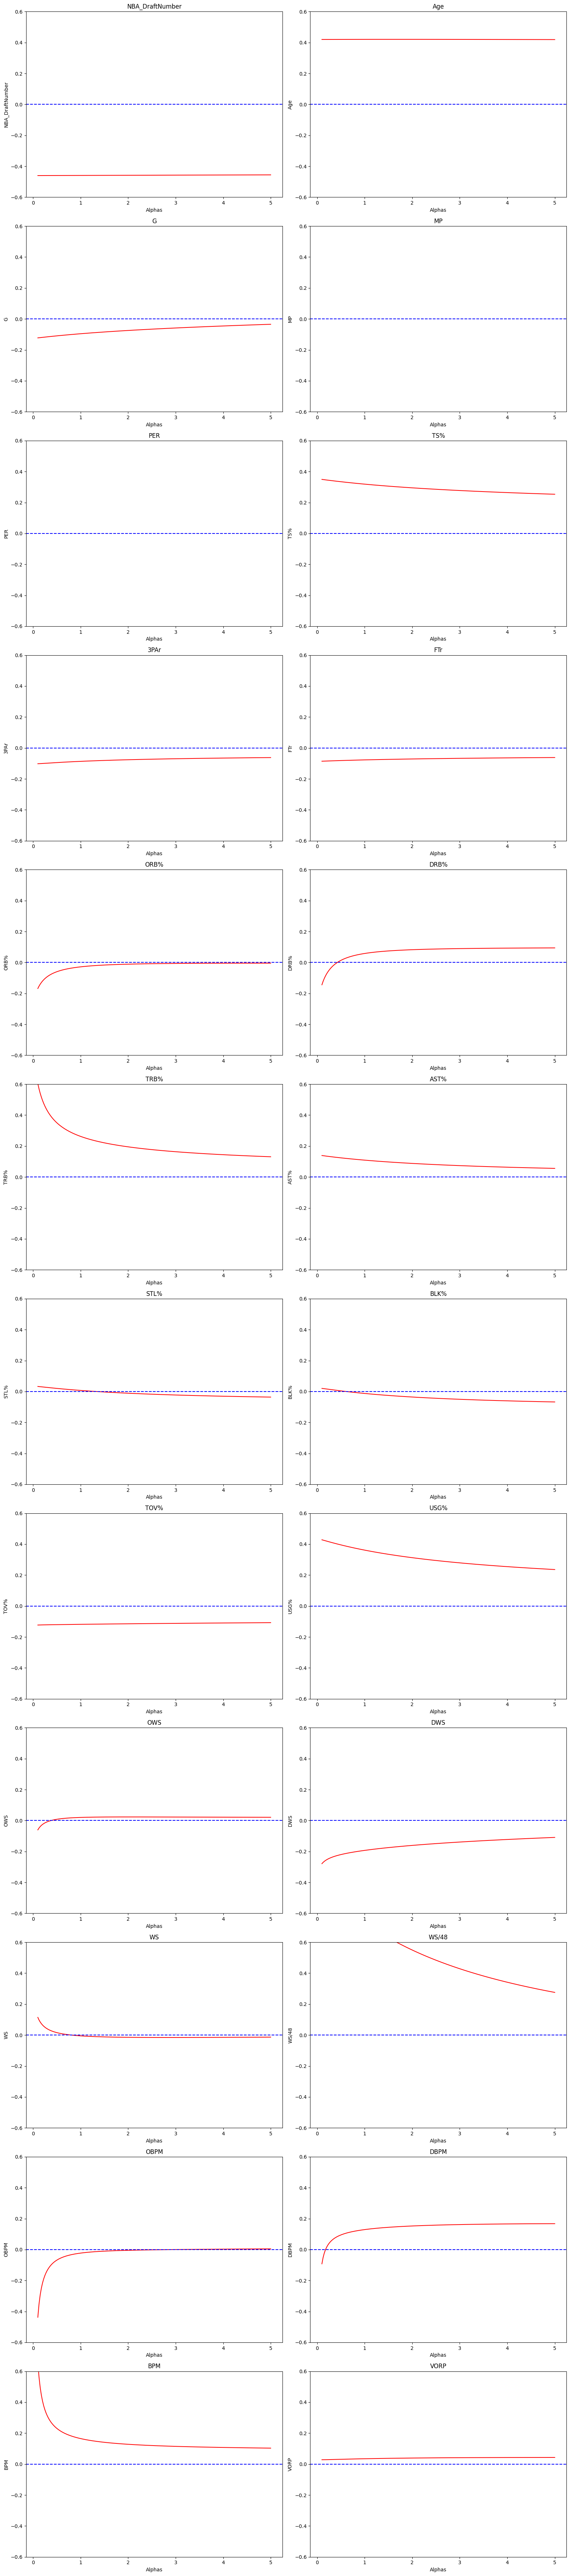

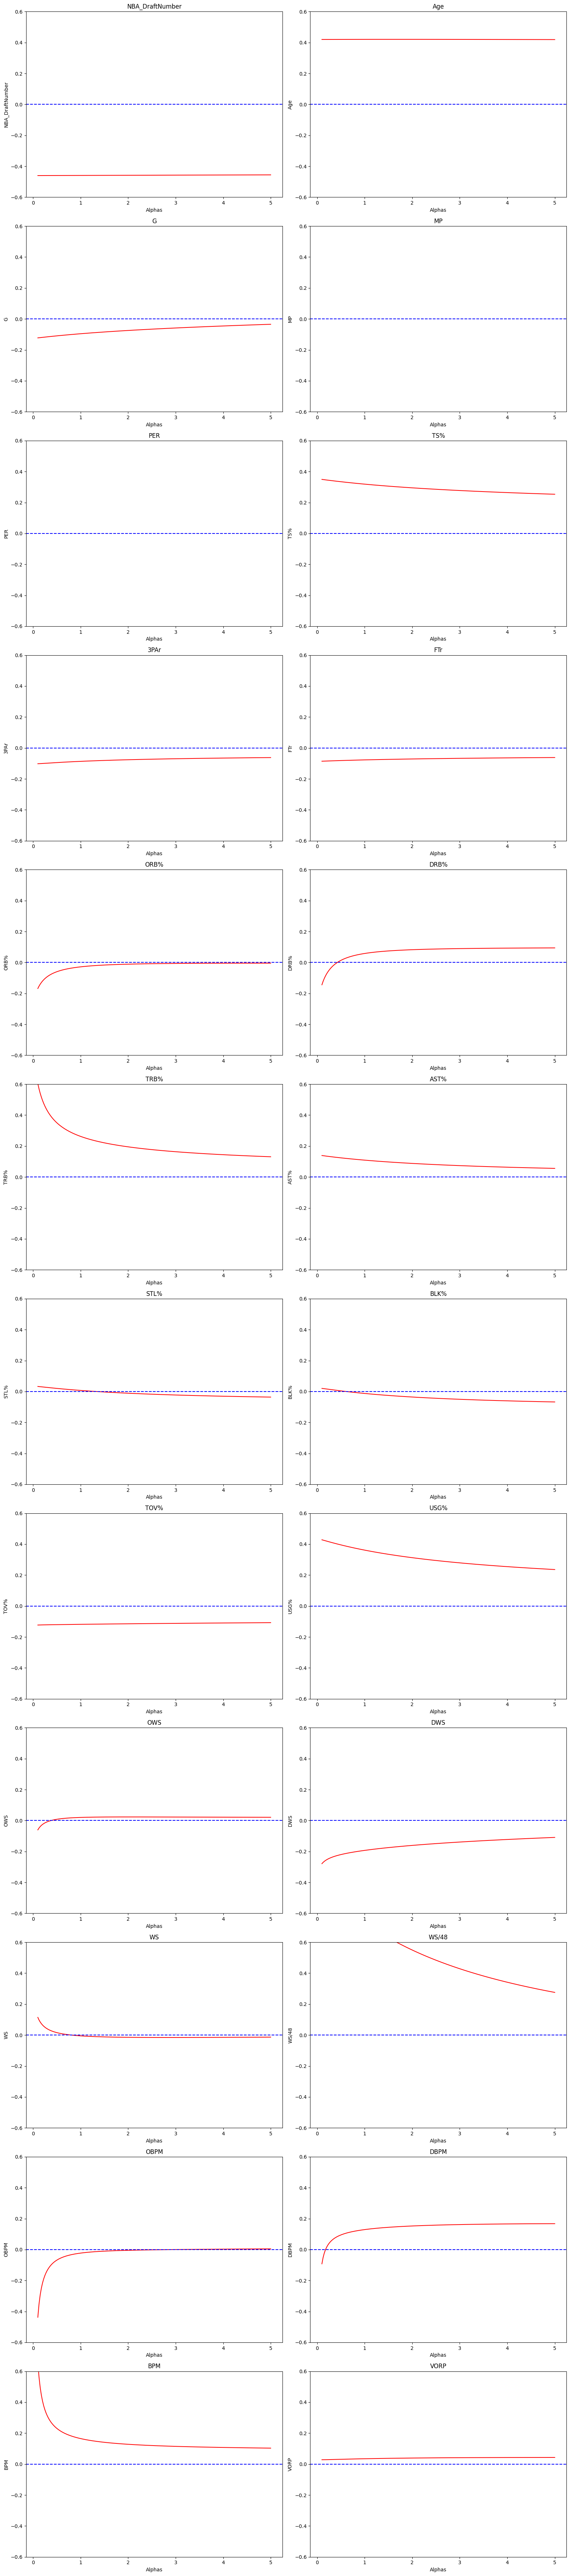

In [78]:
def plot_ridge_path(alphas, coefs, feature_names):
    n_features = len(feature_names)
    n_rows = (n_features + 1) // 2
    fig, axs = plt.subplots(n_rows, 2, figsize=(16, n_rows*6))

    for i, feature_name in enumerate(feature_names):
        row = i // 2
        col = i % 2
        
        ax = axs[row, col]
        
        ax.plot(alphas, [coef[i] for coef in coefs], color='red')
        ax.axhline(y=0, color='b', linestyle='--')
        ax.set_ylim(-0.6, 0.6)
        ax.set_xlabel('Alphas')
        ax.set_ylabel(feature_name)
        ax.set_title(feature_name)
        
        # Hide any remaining subplots
        if i == n_features - 1 and n_features % 2 != 0:
            axs[row, col+1].axis('off')
    
    plt.tight_layout()
    plt.show()

    return fig

plot_ridge_path(alphas, coefs, X_scaled.columns)


According to the charts, we delete G ORB., STL., BLK., OWS, WS, and OBPM; and then check the collinearity again.

In [107]:
remove1 = ['G','ORB%', 'STL%', 'BLK%', 'OWS', 'WS', 'OBPM','Salary', 'LSalary']
print(get_Vif(mydata,response_var=remove1))


           Variable        VIF
1   NBA_DraftNumber   1.313965
2               Age   1.055668
3                MP   6.990533
4               PER  59.533361
5               TS%   5.152700
6              3PAr   3.842350
7               FTr   1.228597
8              DRB%   9.959554
9              TRB%  12.190481
10             AST%   3.171853
11             TOV%   1.674425
12             USG%   6.601473
13              DWS   9.239048
14            WS/48  62.126066
15             DBPM  18.759561
16              BPM  69.026921
17             VORP   3.212974


The collinearity still exists.

* Combing regressors that are involved in collinearity in a meaningful manner
* 1. TR=ORB+DRB TR: Total Rebounds => RPM= TR/MP RPM: Rebounds per Minute 
* 2. PER per Minute: PPM = PER/MP
* 3. OCR = OWS/WS.48
* 4. DCR = DWS/WS.48

In [134]:
newdata = mydata.copy()
newdata['RPM'] = (mydata['ORB%']+mydata['DRB%'])/mydata['MP']
newdata['PPM'] = mydata['PER']/mydata['MP']
newdata['OCR'] = mydata['OWS']/mydata['WS/48']
newdata['DCR'] = mydata['DWS']/mydata['WS/48']

newdata1 = newdata.drop(['Salary', 'MP', 'PER', 'OWS', 'DWS', 'ORB%', 'DRB%', 'WS/48', 'WS', 'OBPM', 'DBPM', 'BPM'], axis=1)
newdata1.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with nan
newdata1.fillna(0, inplace=True)  # Replace nan with 0


print(get_Vif(newdata1,response_var='LSalary'))



           Variable        VIF
1   NBA_DraftNumber   1.262543
2               Age   1.055623
3                 G   4.321365
4               TS%   1.883293
5              3PAr   1.849863
6               FTr   1.207455
7              TRB%   2.453125
8              AST%   2.052643
9              STL%   1.145839
10             BLK%   1.623464
11             TOV%   1.410873
12             USG%   1.711302
13             VORP   2.358068
14              RPM   1.609403
15              PPM   1.528406
16              OCR  10.958103
17              DCR  10.558098


It looks better more, but there still has collinearity.

In [138]:
featuresN = newdata1.columns.tolist()
featuresNew = [feature for feature in featuresN if feature != 'LSalary' ]
features_escapedd = ["Q('{}')".format(feat) if any(char in feat for char in "%/()") or feat[0].isdigit() else feat for feat in featuresNew]
newformula = target1 + " ~ " + " + ".join(features_escapedd)
# print(newformula)

lnfull04 = smf.ols(formula=newformula, data=newdata1).fit()
print(lnfull04.summary())

                            OLS Regression Results                            
Dep. Variable:                LSalary   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     30.88
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           1.99e-65
Time:                        03:52:02   Log-Likelihood:                -693.85
No. Observations:                 483   AIC:                             1424.
Df Residuals:                     465   BIC:                             1499.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.3507      0.544     

Collinearity cannot be solved by above method, we are going to produce next steps.

## 9

* Ridge regression.

In [171]:
from sklearn.linear_model import RidgeCV, Ridge
x = sm.add_constant(X1)
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=None)
ridgecv.fit(x, y)
print(ridgecv.alpha_)

ridge_fit = Ridge(alpha=ridgecv.alpha_).fit(X, y)
pd.Series(ridge_fit.coef_, index = X.columns)

5.0


NBA_DraftNumber   -0.021659
Age                0.099179
G                 -0.001684
MP                 0.000731
PER               -0.082798
TS%                0.443057
3PAr              -0.449426
FTr               -0.117483
ORB%              -0.071647
DRB%              -0.047575
TRB%               0.162407
AST%              -0.000053
STL%              -0.039812
BLK%              -0.008147
TOV%              -0.008266
USG%               0.035186
OWS                0.025867
DWS               -0.063554
WS                -0.002205
WS/48              0.153756
OBPM               0.017514
DBPM              -0.024446
BPM                0.099180
VORP              -0.024198
dtype: float64

* Principal Component Regression

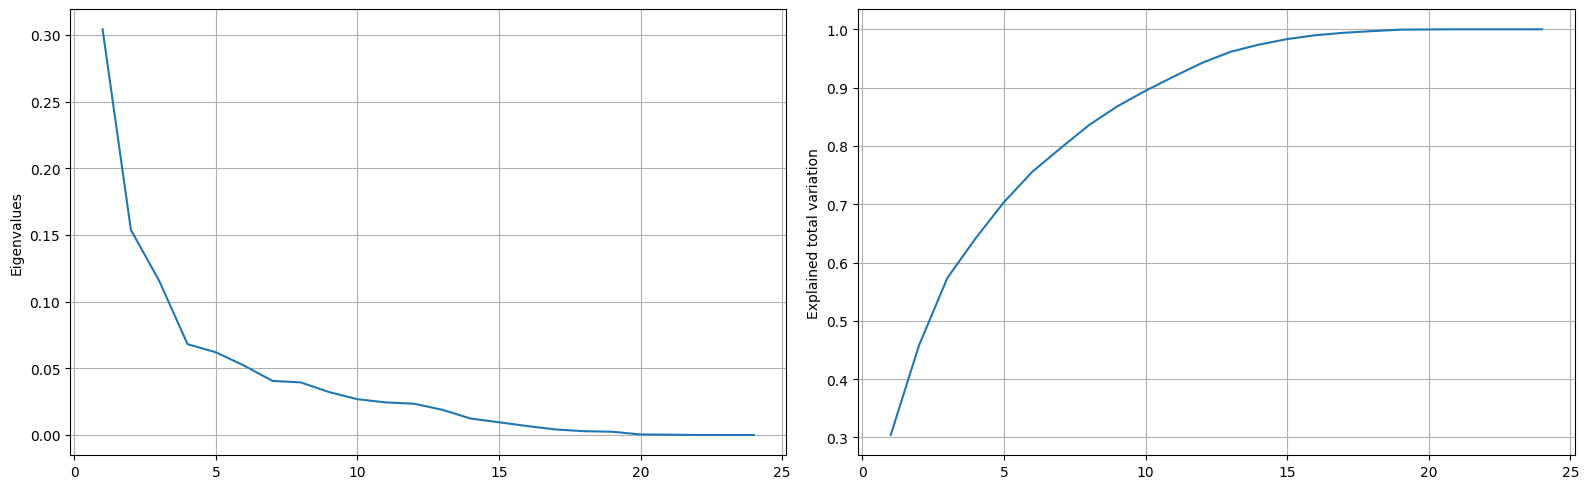

In [158]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

pca = PCA(n_components=X_scaled.shape[1])
pca_full=pca.fit(X_scaled)
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(np.arange(1,X_scaled.shape[1]+1),pca_full.explained_variance_ratio_)
ax[0].set_ylabel('Eigenvalues')
ax[0].grid(True)

ax[1].plot(np.arange(1,X_scaled.shape[1]+1),pca_full.explained_variance_ratio_.cumsum())
# ax[1].axhline(y = 0.85, color = 'r', linestyle = '--')
ax[1].set_ylabel('Explained total variation')
ax[1].grid(True)

plt.tight_layout()
plt.show()

According to the chart, we use 7

In [172]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=7), LinearRegression())
vlist_full = list(X_scaled.columns.values)
print(vlist_full)
X = mydata[vlist_full].copy()
pcr_fit = pcr.fit(X,y)
pca_beta = np.matrix(pcr_fit.named_steps['linearregression'].coef_).T
P_t = np.matrix(pcr_fit.named_steps['pca'].components_).T
beta = np.dot(np.matrix(np.diag(X.std())).I,np.dot(P_t,pca_beta))
intercept=-np.dot(np.matrix(X.mean(0)),beta)
print(np.vstack((intercept,beta)))


['NBA_DraftNumber', 'Age', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
[[-1.71792171e+00]
 [-1.83398031e-03]
 [ 3.29144541e-02]
 [ 5.72446078e-03]
 [ 1.99216878e-04]
 [-2.94745255e-03]
 [-1.88107587e-01]
 [ 1.97182876e-01]
 [-2.43084672e-01]
 [-1.07143478e-03]
 [ 7.01751571e-03]
 [ 6.37545685e-03]
 [ 1.01312884e-03]
 [-3.21590890e-02]
 [-9.49274110e-04]
 [-8.72621199e-03]
 [ 8.29928770e-04]
 [ 8.94183249e-02]
 [ 1.50508430e-01]
 [ 6.68281686e-02]
 [-2.19752712e-01]
 [-7.05560684e-04]
 [ 2.05882053e-02]
 [ 3.10972395e-03]
 [ 1.22589334e-01]]


* Partial Least Square Regression


In [162]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=4, scale=True)
pls_fit = pls.fit(X, y)
print(pls_fit.coef_)

[[-0.48634452  0.43210705  0.1770186   0.26448578 -0.06330524  0.09680279
  -0.04803697 -0.0490035  -0.0436402   0.08811762  0.04126927  0.03761682
  -0.04165125 -0.08780579 -0.0632499   0.07244577  0.03275603  0.07728021
   0.05352452 -0.07868728  0.00702754  0.07710686  0.03930637 -0.00201836]]


* Elastic net

In [188]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet, ElasticNetCV 
warnings.filterwarnings("ignore")

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define grid
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
ratios = np.arange(0.01, 1, 0.01)  # Start from 0.01

model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
results = model.fit(X, y)

EN_model = ElasticNet(alpha=results.alpha_, l1_ratio=results.l1_ratio_)
EN_fit = EN_model.fit(X, y)

print(f'The best alpha: {results.alpha_}. The best Lambda: {results.l1_ratio_}')
EN_fit.coef_


The best alpha: 1.0. The best Lambda: 0.35000000000000003


array([-0.02230017,  0.07787943,  0.        ,  0.00080821, -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.01649376,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ])

## 10

In [182]:

Err_Ridge = np.zeros((len(y),1))
Err_pcr = np.zeros((len(y),1))
Err_pls = np.zeros((len(y),1))
Err_EN = np.zeros((len(y),1))
y.index = np.array(range(0,len(y)))
X.index = np.array(range(0,len(y)))
for i in range(0,len(y)):
    act_lst = np.setdiff1d(np.array(range(0,len(y))),np.array(i))
    iX = X.iloc[act_lst,:].copy()
    iy = y[act_lst].copy()
    fit1 = Ridge(alpha=ridgecv.alpha_).fit(iX, iy)
    fit2 = pcr.fit(iX,iy)
    fit3 = pls.fit(iX,iy)
    fit4 = EN_model.fit(iX,iy)
    
    Err_Ridge[i] = (y[i] - fit1.predict(X.iloc[[i], :]))**2
    Err_pcr[i] = (y[i] - fit2.predict(X.iloc[[i], :]))**2
    Err_pls[i] = (y[i] - fit3.predict(X.iloc[[i], :]))**2
    Err_EN[i] = (y[i] - fit4.predict(X.iloc[[i], :]))**2
    
mean_errors = {
    "Ridge": Err_Ridge.mean(),
    "PCR": Err_pcr.mean(),
    "PLS": Err_pls.mean(),
    "ElasticNet": Err_EN.mean()
}

mean_errors

{'Ridge': 1.1579784664968293,
 'PCR': 1.4740355968938708,
 'PLS': 1.158504070770569,
 'ElasticNet': 1.0739822269426857}

Eslatic Net is the smaller one

## 11

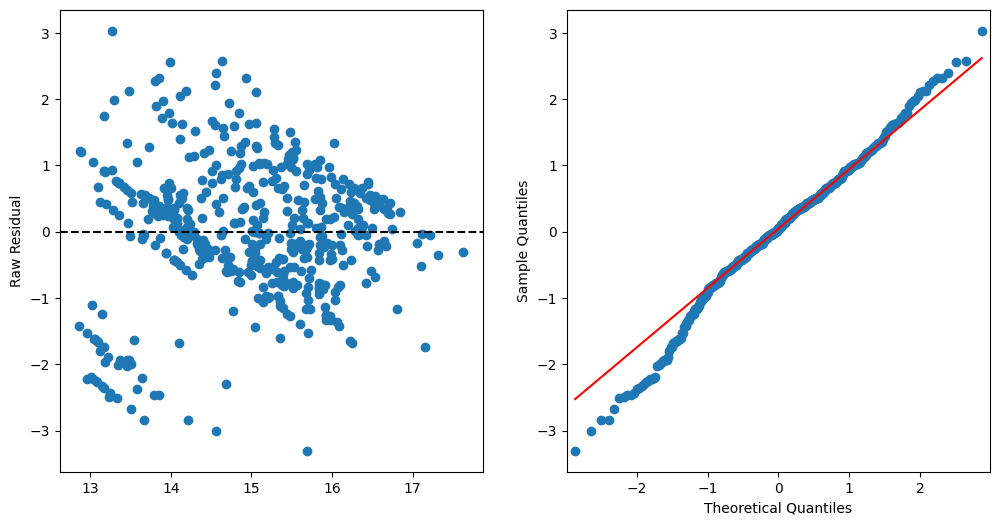

In [174]:
yhat = EN_fit.predict(X)
FinalM_resid = y - yhat # raw residuals
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(yhat,FinalM_resid)
ax1.set_ylabel('Raw Residual')
ax1.axhline(y=0, color='black', linestyle='--')
ax2 = fig.add_subplot(1,2,2)
sm.qqplot(FinalM_resid,line='q',ax=ax2)
plt.show()

In [175]:
nomal = test_normality(FinalM_resid)
print(nomal)

            Test Name  Test Statistic  p_value
0        Shapiro-Wilk         0.98744  0.00036
1  Kolmogorov-Smirnov         0.05412  0.00287
2    Cramer-von Mises         0.26496  0.17028
3    Anderson-Darling         2.02710  0.00004


The normality assumption is passed

* Test Independence

In [177]:
from statsmodels.stats.stattools import durbin_watson
checkIndp = durbin_watson(FinalM_resid)
print(checkIndp)
sm.stats.runstest_1samp(FinalM_resid)

1.9158693345671294


(-0.9412717624368271, 0.3465656095036329)

Runs test and Durbinwaston test all passed the independence hypothesis.
There are no obvious serious violation thorugh the residuals analysis.